数据集：
股票(30支股票，以天计数)
https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231


based：
https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [61]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

数据分析阶段

In [62]:
# 数据集导入
df = pd.read_csv("stock/AABA_2006-01-01_to_2018-01-01.csv")
df = df.drop(["Name"],axis=1)
df.head()


,Date,Open,High,Low,Close,Volume
0,2006-01-03,39.69,41.22,38.79,40.91,24232729
1,2006-01-04,41.22,41.90,40.77,40.97,20553479
2,2006-01-05,40.93,41.73,40.85,41.53,12829610
3,2006-01-06,42.88,43.57,42.80,43.21,29422828
4,2006-01-09,43.10,43.66,42.82,43.42,16268338


In [63]:
date_time = pd.to_datetime(df.pop('Date'))

In [64]:
df.head()

,Open,High,Low,Close,Volume
0,39.69,41.22,38.79,40.91,24232729
1,41.22,41.90,40.77,40.97,20553479
2,40.93,41.73,40.85,41.53,12829610
3,42.88,43.57,42.80,43.21,29422828
4,43.10,43.66,42.82,43.42,16268338


拆分数据,将对(70%, 20%, 10%)训练、验证和测试集使用拆分

In [65]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
# 训练集，验证集和测试集
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
# 特征
num_features = df.shape[1]

In [66]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df-train_mean)/train_std

In [67]:
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

**数据窗口**


将会构建多种模型（包括linear,DNN,CNN,RNN模型）
1. 单输出和多输出预测
2. 单时间步和多时间步预测

In [68]:
train_df.head()

,Open,High,Low,Close,Volume
0,2.339566,2.477879,2.293832,2.508760,0.002214
1,2.540008,2.566110,2.556679,2.516641,-0.185600
2,2.502016,2.544053,2.567299,2.590190,-0.579878
3,2.757481,2.782795,2.826164,2.810839,0.267151
4,2.786302,2.794473,2.828819,2.838420,-0.404342


定义一个windowGenrator类，实现功能有
1. 如上图所示处理索引和偏移量。
2. 将特征窗口分成(features, labels)对。
3. 绘制结果窗口的内容。
4. tf.data.Dataset使用s.从训练、评估和测试数据中高效地生成这些窗口的批次。

In [69]:
class WindowGenerator():
    def __init__(self,input_width,label_width,shift,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=None):
        '''该__init__方法包括输入和标签索引的所有必要逻辑。
        它还将训练、评估和测试数据帧作为输入。
        这些将在稍后转换为tf.data.Dataset窗口。'''
        self.train_df= train_df
        self.test_df = test_df
        self.val_df = val_df

        self.input_width=input_width
        self.label_width = label_width
        self.shift = shift


        # 定义类别的列
        self.label_columns=label_columns

        if label_columns is not None:
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.columns_indices = {name:i for i,name in enumerate(train_df.columns)}


        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        '''打印数据'''
        return '\n'.join([
            f'Total window size总窗口大小: {self.total_window_size}',
            f'Input indices输入索引: {self.input_indices}',
            f'Label indices标签索引: {self.label_indices}',
            f'Label column name(s)标签列名: {self.label_columns}'])

测试类中的函数

In [70]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.columns_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [71]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.columns_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [72]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [73]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

----------------------
# 1. single step model
- ​	    baseline
- ​     linear
- ​     dense
- ​     multi-dense
- ​     conv
- ​     rnn
- ​     total
- ​     multi-output models
  
# 2. multi-step model
-  baselines
- single-hot models
- autogress model
- total
  


In [74]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

配置一个WindowGenerator对象以生成这些单步(input, label)对：

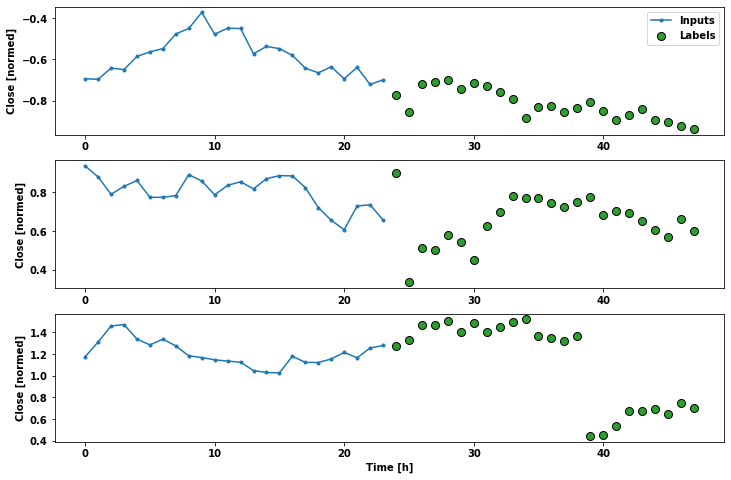

In [75]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
# multi_window

# <u>multi-step-model:baseline</u>

<img src ='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_last.png'>

18/18 [==============================] - 0s 1ms/step - loss: 0.2803 - mean_absolute_error: 0.2921


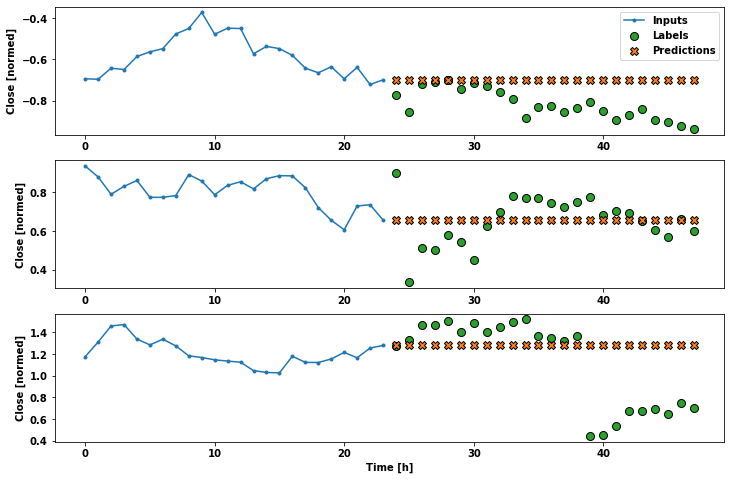

In [76]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:,-1:,:],[1,OUT_STEPS,1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

由于这项任务是预测未来24小时，考虑到过去24小时，另一种简单的方法是重复前一天，假设明天类似：
<img src = 'https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_repeat.png'>

18/18 [==============================] - 0s 1ms/step - loss: 0.4059 - mean_absolute_error: 0.4053


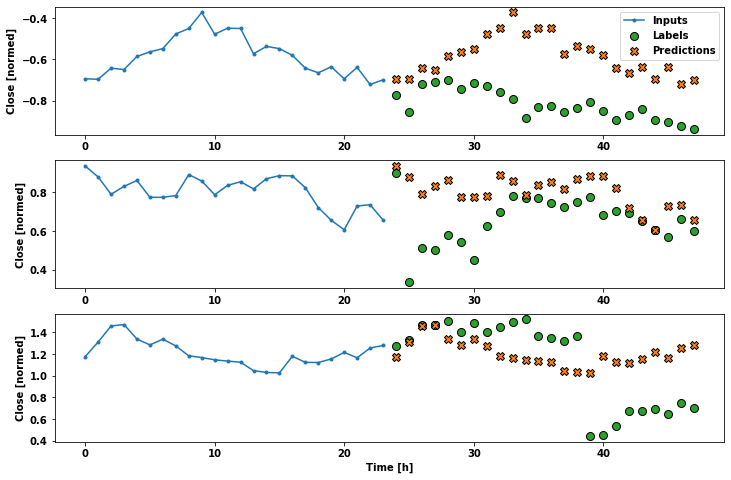

In [77]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# <u>multi-step-model:single-shot models</u>

<img src ='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_dense.png'>


include:
- linear
- dense
- cnn
- rnn


# mutli-step-model-single-shot-model:linear



<img src = 'https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_dense.png'>

18/18 [==============================] - 0s 1ms/step - loss: 0.2298 - mean_absolute_error: 0.3140


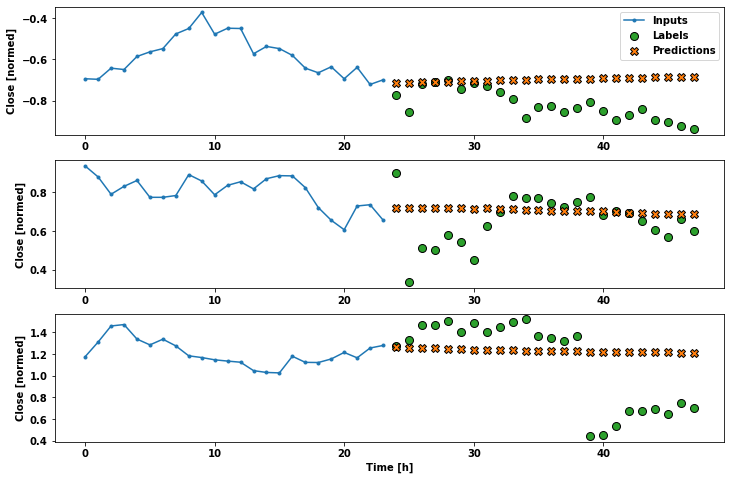

In [78]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# mutli-step-model-single-shot-model:dense

18/18 [==============================] - 0s 1ms/step - loss: 0.2154 - mean_absolute_error: 0.2933


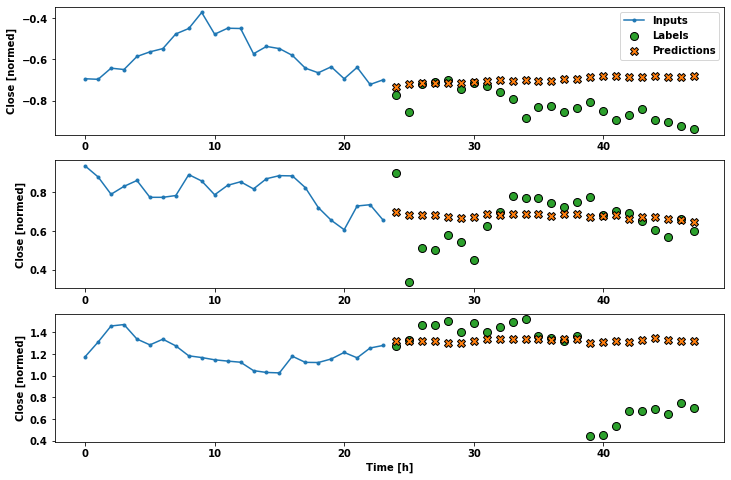

In [79]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)



# mutli-step-model-single-shot-model:cnn
<img src ='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_conv.png'>




18/18 [==============================] - 0s 1ms/step - loss: 0.2498 - mean_absolute_error: 0.3353


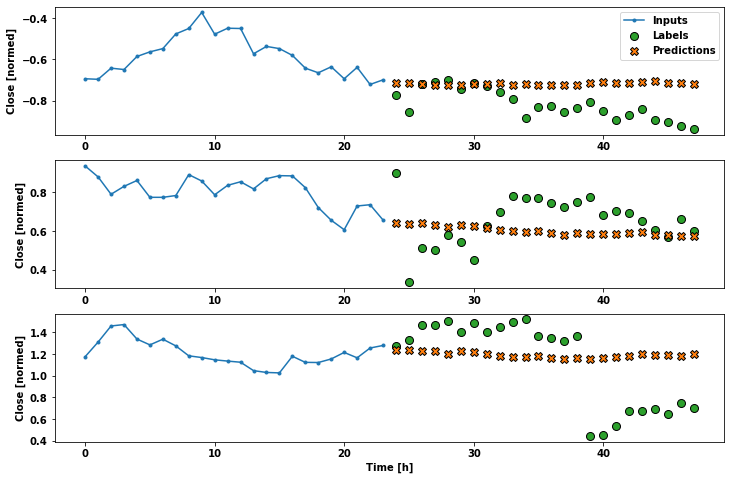

In [80]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


# mutli-step-model-single-shot-model:rnn
<img src ='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_lstm.png'>

18/18 [==============================] - 0s 3ms/step - loss: 0.4571 - mean_absolute_error: 0.4881


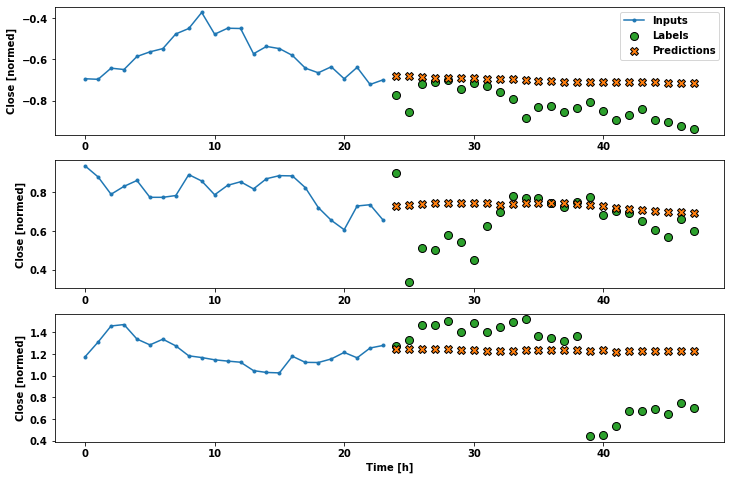

In [81]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


# mutli-step-model-Advanced: Autoregressive model
<img src ='https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_autoregressive.png'>

In [82]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [83]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [84]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 5])

In [85]:
def call(self,inputs,training=None):
  # 使用TensorArray去捕获动态输出
  predictions = []
  # 初始化lstm状态
  prediction,state= self.warmup(inputs)

  # 输入第一个预测
  predictions.append(prediction)

  # 跑剩下的预测
  for n in range(1,self.out_steps):
    # 使用最后的预测作为输入
    x = prediction

    # 执行lstm step
    x,state = self.lstm_cell(x,states=state,training=training)

    # 转换lstm输出去预测
    prediction = self.dense(x)
    # 增加预测去到输出
    predictions.append(prediction)

  # 预测的shape=>(time,batch,features)
  predictions = tf.stack(predictions)
  # 预测.shape =>(hatch,time,features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions
FeedBack.call = call

18/18 [==============================] - 0s 4ms/step - loss: 0.5096 - mean_absolute_error: 0.5144


Exception ignored in: <function ScopedTFGraph.__del__ at 0x7fd9ea9e8820>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/framework/c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 


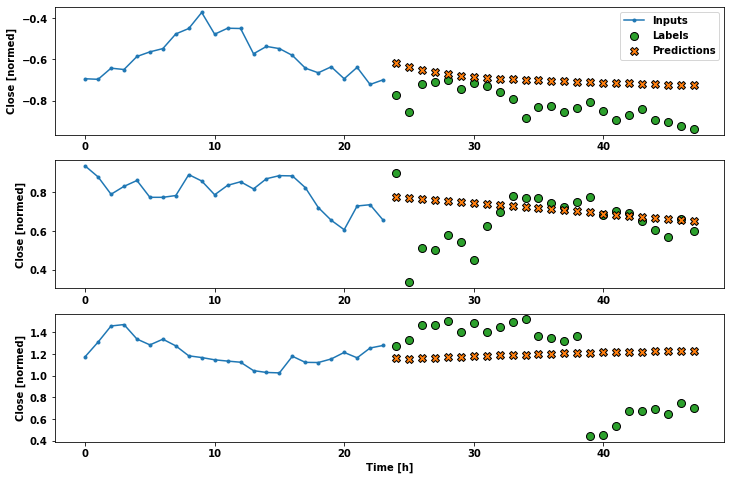

In [86]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# multi-step-model综述

In [89]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2978
Repeat  : 0.4338
Linear  : 0.4438
Dense   : 0.3869
Conv    : 0.5841
LSTM    : 1.7944
AR LSTM : 1.8727
